### ReadME

- Baseball ML Project: Building a fun, completely free/open source website that predicts the outcome of baseball games using machine learning. 

- Goal: Launch Website, Implement Neural Net, Achieve Predictive Accuracy, α > 70%

### To-Do List: 

- Reverse search: Need to be able to find the team that a given player is currently playing for

- Need to turn raw daily lineups into usable lineups, ie. split into each individual team, pull stats easily for each player, convert to a dataframe 

- Update Model once able to source data properly and consistently.

### Dependencies

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', None), pd.set_option('display.max_rows', None)
from pandas import DataFrame

from datetime import date

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics 

import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

import pybaseball as pyb
#team game logs will return lagging stats -- schedule is not fully displayed 
from pybaseball import team_game_logs
#schedule and record will give a full list of games that have or haven't occured
from pybaseball import schedule_and_record
from pybaseball import playerid_reverse_lookup
from pybaseball import team_batting

from bs4 import BeautifulSoup
import requests 


import streamlit as st

### Web Scraping Functions for Daily Lineups

In [ ]:
#date must be formatted like so ('YYYY-MM-DD')
#returns a list that contains sublists that hold the full lineups for each individual game on a given date
#first two values are the two pitchers (first one is away, second is home), next 9 values is the organized starting lineup for the away team
#then, last 9 values is the organized starting lineup for the home team
#an index range of 20 values containing all the players playing in a given game (for both teams)

def get_raw_lineups(date):
    raw_url = 'https://www.baseballpress.com/lineups/{}'
    url_date = raw_url.format(date)
    source = requests.get(url_date).text
    soup = BeautifulSoup(source, 'lxml')
    divs = soup.find_all('div', class_="player")
    todays_players = pd.DataFrame()
    mylist = []
    for item in divs:
        player = item.find('a').text
        mylist.append(player)
    
    todays_players['Players'] = mylist
    new_list = []
    for n in todays_players.Players:
        new_list.append(n[:n.find('.')-1])
    i = 0 
    array = new_list
    output = [array[i:i + 20]for i in range(0, len(array), 20)]
    return output

#in pulling data from baseballpress, sometimes player names are jacked up, this function tries to reformat all names so that-
#they are on equal footing and easier to handle 
def reform_names(date):
    new_list = []
    for n in v.Players:
        new_list.append(n[:n.find('.')-1])
    return new_list

### Decision Tree Model (not updated)

In [78]:
data = pd.read_csv('0821log.csv')


X = data.drop(columns = ['Date', 'home_team', 'away_team', 'home_pitcher', 'away_pitcher', 'Result'])
y = data['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier()

model.fit(X, y)

DecisionTreeClassifier()

### Model Predict Function

In [37]:
#uses the DC model to predict an outcome between two teams 
def predict(team, team2):
    dataset = create_df(team, team2)
    t1_pqm = dataset.t1_pqm
    t2_pqm = dataset.t2_pqm
    t1_elo = dataset.t1_elo
    t2_elo = dataset.t2_elo
    t1_era = dataset.t1_era
    t2_era = dataset.t2_era
    t1_bb9 = dataset.t1_bb9
    t2_bb9 = dataset.t2_bb9
    t1_fip = dataset.t1_fip
    t2_fip = dataset.t2_fip
    t1_ba = dataset.t1_ba
    t2_ba = dataset.t2_ba
    t1_ops = dataset.t1_ops
    t2_ops = dataset.t2_ops
    t1_so = dataset.t1_so
    t2_so = dataset.t2_so
    df = pd.DataFrame({'t1_pqm':t1_pqm,' t2_pqm':t2_pqm,'t1_elo':t1_elo, 't2_elo':t2_elo,
                      't1_era':t1_era, 't2_era':t2_era, 't1_bb9':t1_bb9,'t2_bb9': t2_bb9,
                     't1_fip':t1_fip, 't2_fip':t2_fip,'t1_so':t1_so,'t2_so':t2_so, 't1_ba':t1_ba,'t2_ba':t2_ba,'t1_ops':t1_ops,
                      't2_ops':t2_ops})
    #features = [t1_pqm,t2_pqm,t1_elo,t2_elo,t1_era,t2_era,t1_bb9,t2_bb9,t1_fip,t2_fip,
                          #t1_ba,t2_ba,t1_ops,t2_ops,t1_so,t2_so]
    prediction = model.predict(df)
    if prediction == np.array(1):
        outcome = print('The Oracle predicts that', team2, 'will win')
    if prediction == np.array(0):
        outcome = print('The Oracle predicts that', team, 'will win')

    return outcome
predict('MIN', 'BOS')

The Oracle predicts that BOS will win


### Functions

In [ ]:
#returns filtered/munged batting stats for any team. Removes NAN and pitchers, as well as other unwanted things
def get_organized_stats(team):
    
    base_df = get_batting(team, 2021)
    
    filtered_out_strings = base_df[base_df.AB != 'AB']
    
    final_df = filtered_out_strings[filtered_out_strings.Pos != 'P']
    
    final_df = final_df[final_df.Pos.notnull()]

    return final_df


#gets individual player batting stats
def get_player_batting(team, player):
    v = get_batting(team, 2021)
    i = 0 
    while i < len(v.Name):
        if player in v.Name[i]:
            stats = v[v.Name == v.Name[i]]
        i+=1
    return stats
#gets individual player pitching stats 
def get_player_pitching(team, player):
    v = get_pitching(team, 2021)
    i = 0 
    while i < len(v.Name):
        if player in v.Name[i]:
            stats = v[v.Name == v.Name[i]]
        i+=1
    return stats
#get_player_pitching('TBR', 'Tyler Glas')

In [ ]:
#pulls hitting data from baseball reference for a specified team and year
def get_batting (team, year):
    url = 'https://www.baseball-reference.com/teams/{}/{}.shtml#all_team_batting'
    next_url = url.format(team, year)
    data = pd.read_html(next_url, header = 0)
    return data[-2]


#pulls pitching data from baseball reference for a specified team and year
def get_pitching (team, year):
    url = 'https://www.baseball-reference.com/teams/{}/{}.shtml#team_pitching'
    next_url = url.format(team, year)
    data = pd.read_html(next_url)
    return data[-1]

#removes day of the week from date
def clean_date(team):
    k = schedule_and_record(2021, team)
    b = k.Date
    my_list = []
    for i in b:
        if "," in i:
            param, value = i.split(",",1)
            my_list.append(value)
    k['Date'] = my_list
    return k

#list of all teams
all_teams = ['TBR', 'BOS', 'NYY', 'TOR', 'BAL', 'CHW', 'CLE', 'DET', 'KC', 'MIN', 'HOU', 'OAK',
           'SEA', 'LAA', 'TEX','NYM','PHI', 'ATL', 'WSN', 'MIA', 'MIL', 'CIN', 'STL', 'CHC', 'PIT',
          'SF', 'LAD', 'SD', 'COL', 'ARI']

#takes in one team as an arg and spits out todays matchup for that team along with probable pitchers 
def get_today(team):
    try:
        u = 'https://www.baseball-reference.com/teams/{}/2021.shtml#team_pitching'
        next_u = u.format(team)
        d = pd.read_html(next_u)
        matchup = d[0].drop(columns = [1, 2])
        matchup.rename(columns = {0:'Date'}, inplace = True)
        param, value = matchup.Date[0].split(",",1)
        matchup.replace(matchup.Date[0], param, inplace = True)
        pitchers = d[1]
        pitchers.rename(columns = {0:'Team', 1:'Pitchers'}, inplace = True)
        home_starter = pitchers.Pitchers[1]
        away_starter = pitchers.Pitchers[0]
        listy = ['date', away_starter, home_starter]
        pitchers.rename(columns = {0:'Team', 1:'Pitchers'}, inplace = True)
        matchup['Pitchers'] = listy
    except: 
        home_starter = 'undefined'
        away_starter = 'undefined'
        pass
    return matchup

#takes in a team as an arg and spits out the home team in its current matchup
def get_home(team):
    try:
        u = 'https://www.baseball-reference.com/teams/{}/2021.shtml#team_pitching'
        next_u = u.format(team)
        d = pd.read_html(next_u)
        matchup = d[1]
        matchup.rename(columns = {0:'Team'}, inplace = True)
        homeTeam = matchup.Team[1]
        awayTeam = matchup.Team[0]
    except: 
        homeTeam = 'undefined'
        awayTeam = 'undefined'
        pass
    return homeTeam

#pqm is the self created pitcher quality metric. takes in a collection of important pitcher stats to get a better overall view
def pqm(team, pitcher_name):
    team_data = get_pitching(team, 2021)
    pitcher_data = team_data[team_data['Name'].str.contains(pitcher_name)]
    era = float(pitcher_data.ERA.iloc[0])
    whip = float(pitcher_data.WHIP.iloc[0])
    bb9 = float(pitcher_data.BB9.iloc[0])
    fip = float(pitcher_data.FIP.iloc[0])
    pqm = round((((era * fip)/2)* (whip * bb9))/2)
    return pqm
#single number metric - function of win loss
def elo(team):
    team_sr = schedule_and_record(2021, team)
    team_sr.rename(columns = {'W/L' : 'Result', 'W-L' : 'Record'}, inplace = True)
    num_wins = team_sr.Result.str.count('W').sum()
    num_losses = team_sr.Result.str.count('L').sum()
    elo = 1500 + (25 * num_wins) - (25 * num_losses)
    return elo
#creates df for training -- give it two teams that are playing today, and it will pull all the pregame metrics for those teams
def create_df(team, team2):
    data = get_today(team)
    p1 = data.Pitchers[1]
    p2 = data.Pitchers[2]
    t1 = data.Date[1]
    t2 = data.Date[2]
    data['t1_pqm'] = pqm(team, p1)
    data['t2_pqm'] = pqm(team2, p2)
    data['t1_elo'] = elo(team)
    data['t2_elo'] = elo(team2)
    data['home_team'] = t2
    data['away_team'] = t1
    data['home_pitcher'] = p2
    data['away_pitcher'] = p1
    data['t1_era'] = get_era(team, p1)
    data['t2_era'] = get_era(team2, p2)
    data['t1_bb9'] = get_bb9(team, p1)
    data['t2_bb9'] = get_bb9(team2, p2)
    data['t1_fip'] = get_fip(team, p1)
    data['t2_fip'] = get_fip(team2, p2)
    data['t1_so'] = get_so(team, p1)
    data['t2_so'] = get_so(team2, p2)
    data['t1_ba'] = get_ba(team)
    data['t2_ba'] = get_ba(team2)
    data['t1_ops'] = get_ops(team)
    data['t2_ops'] = get_ops(team2)
    data.drop(data.index[[1,2]], inplace= True)
    data.drop(columns = 'Pitchers', inplace = True)
    return data 
#get earned run average for a given pitcher
def get_era(team, pitcher_name):
    team_data = get_pitching(team,2021)
    pitcher_data = team_data[team_data['Name'].str.contains(pitcher_name)]
    era = float(pitcher_data.ERA.iloc[0])
    return era
#get walks per 9 innings  for a given pitcher
def get_bb9(team, pitcher_name):
    team_data = get_pitching(team,2021)
    pitcher_data = team_data[team_data['Name'].str.contains(pitcher_name)]
    bb9 = float(pitcher_data.BB9.iloc[0])
    return bb9
#fielding independent pitching for a given pitcher
def get_fip(team, pitcher_name):
    team_data = get_pitching(team,2021)
    pitcher_data = team_data[team_data['Name'].str.contains(pitcher_name)]
    fip = float(pitcher_data.FIP.iloc[0])
    return fip
#walks hits per innings pitched 
def get_whip(team, pitcher_name):
    team_data = get_pitching(team,2021)
    pitcher_data = team_data[team_data['Name'].str.contains(pitcher_name)]
    whip = float(pitcher_data.WHIP.iloc[0])
    return whip
#total strikeouts for a given pitcher 
def get_so(team, pitcher_name):
    team_data = get_pitching(team,2021)
    pitcher_data = team_data[team_data['Name'].str.contains(pitcher_name)]
    so = float(pitcher_data.SO.iloc[0])
    return so
#batting average for a team 
def get_ba(team):
    team_data = team_game_logs(2021, team)
    ba = team_data.BA
    current_ba = ba.iloc[-1]
    return current_ba
#ops for a team 
def get_ops(team):
    team_data = team_game_logs(2021, team)
    ops = team_data.OPS
    current_ops = ops.iloc[-1]
    return current_ops

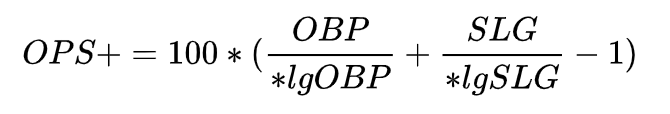